BaseLine Models

# Imports and data loading

In [3]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import joblib

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, RocCurveDisplay,
    ConfusionMatrixDisplay
)

# Load preprocessor and train/test splits saved from the preprocessing notebook
preprocessor = joblib.load("preprocessor.pkl")
X_train = joblib.load("X_train.pkl")
X_test = joblib.load("X_test.pkl")
y_train = joblib.load("y_train.pkl")
y_test = joblib.load("y_test.pkl")

print("train shape:", X_train.shape, y_train.shape)
print("test shape :", X_test.shape, y_test.shape)

try:
    # If the preprocessor is already fitted, just transform
    X_train_proc = preprocessor.transform(X_train)
    X_test_proc = preprocessor.transform(X_test)
except Exception:
    # If not fitted yet, fit on train and transform both
    X_train_proc = preprocessor.fit_transform(X_train)
    X_test_proc = preprocessor.transform(X_test)

print("Processed train shape:", X_train_proc.shape, y_train.shape)
print("Processed test shape :", X_test_proc.shape, y_test.shape)

train shape: (1000, 26) (1000,)
test shape : (250, 26) (250,)
Processed train shape: (1000, 1299) (1000,)
Processed test shape : (250, 1299) (250,)


### Baseline models — Logistic Regression, Decision Tree, KNN, SVM

In this notebook, we train and evaluate simple baseline models before any hyperparameter tuning. These baselines will serve as a reference to compare with advanced ensemble models and tuned versions in later steps. All models are evaluated on the same train/test split.

In [1]:
# Metrics + ROC + confusion matrix
def evaluate_model(model, X_tr, y_tr, X_te, y_te, name="Model"):
    """
    Fit the model (if not already fitted), compute predictions and probabilities,
    print main metrics, and display ROC curve + confusion matrix.
    """
    # Fit if needed
    try:
        _ = model.predict(X_te)
    except Exception:
        model.fit(X_tr, y_tr)

    # Predictions
    y_pred = model.predict(X_te)

    # Probabilities
    y_prob = None
    if hasattr(model, "predict_proba"):
        try:
            y_prob = model.predict_proba(X_te)[:, 1]
        except Exception:
            pass
    elif hasattr(model, "decision_function"):
        try:
            y_prob = model.decision_function(X_te)
        except Exception:
            pass

    # Metrics
    print(f"\n{name} — Test set metrics")
    print("Accuracy : ", f"{accuracy_score(y_te, y_pred):.3f}")
    print("Precision:", f"{precision_score(y_te, y_pred):.3f}")
    print("Recall   :", f"{recall_score(y_te, y_pred):.3f}")
    print("F1-score :", f"{f1_score(y_te, y_pred):.3f}")
    if y_prob is not None:
        print("ROC-AUC  :", f"{roc_auc_score(y_te, y_prob):.3f}")

        RocCurveDisplay.from_predictions(y_te, y_prob)
        plt.title(f"ROC Curve — {name}")
        plt.show()

    # Confusion matrix
    ConfusionMatrixDisplay.from_predictions(y_te, y_pred, cmap="Blues")
    plt.title(f"Confusion Matrix — {name}")
    plt.show()

# Logistic Regression


Logistic Regression — Test set metrics
Accuracy :  0.768
Precision: 0.798
Recall   : 0.722
F1-score : 0.758
ROC-AUC  : 0.836


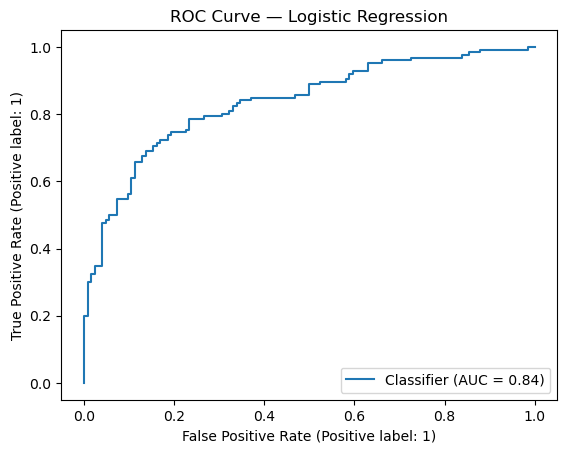

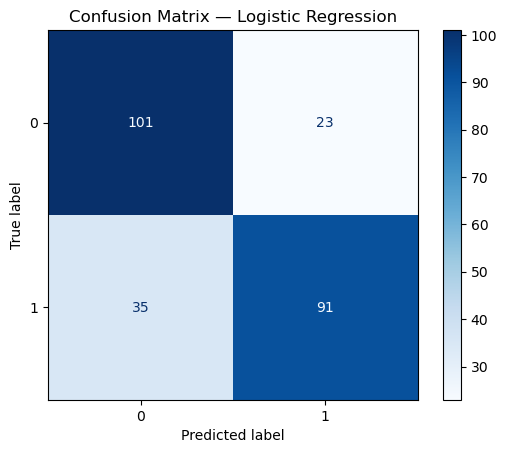

In [4]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(
    max_iter=1000,
    solver="lbfgs"
)

log_reg.fit(X_train_proc, y_train)

evaluate_model(
    log_reg,
    X_train_proc, y_train,
    X_test_proc, y_test,
    name="Logistic Regression"
)

#### Logistic Regression — Model Evaluation

The Logistic Regression model provides a solid baseline for predicting whether an employee may be at risk of developing mental health issues based on workplace conditions and personal habits.

- **Accuracy:** 0.768  
- **Precision:** 0.798  
- **Recall:** 0.722  
- **F1-score:** 0.758  
- **ROC-AUC:** 0.836  

These results indicate that the model achieves a good balance between correctly identifying at-risk employees (recall) and avoiding false positives (precision). The ROC-AUC score of **0.836** suggests strong discriminative ability overall.

**Confusion Matrix:**
The model correctly classifies a large proportion of both classes (101 true negatives and 91 true positives). However, some at-risk employees are still misclassified as not at-risk (35 false negatives), which remains an important challenge in this context.

# Decision Tree


Decision Tree — Test set metrics
Accuracy :  0.732
Precision: 0.771
Recall   : 0.667
F1-score : 0.715
ROC-AUC  : 0.733


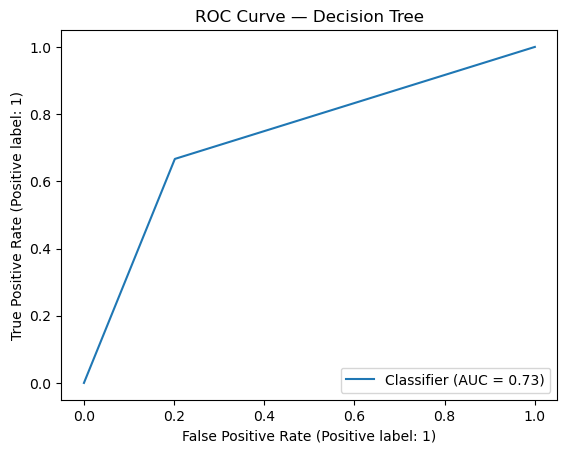

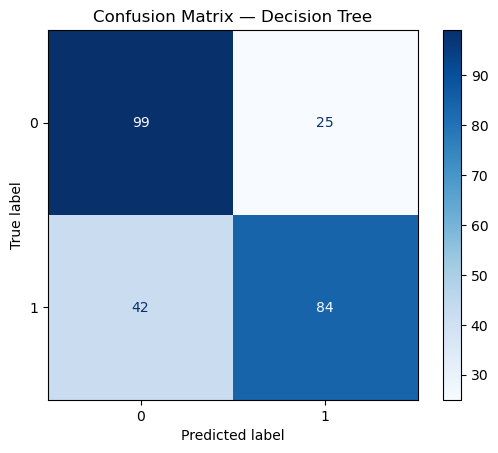

In [5]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(
    random_state=42
)

dt.fit(X_train_proc, y_train)

evaluate_model(
    dt,
    X_train_proc, y_train,
    X_test_proc, y_test,
    name="Decision Tree"
)

### Decision Tree — Model Evaluation

- **Accuracy:** 0.732  
- **Precision:** 0.771  
- **Recall:** 0.667  
- **F1-score:** 0.715  
- **ROC-AUC:** 0.733  

The Decision Tree classifier demonstrates slightly lower overall performance compared to Logistic Regression. It achieves a good precision but struggles more with recall, meaning it misses a higher proportion of employees who are actually at risk of mental health issues.

The confusion matrix shows that the model correctly identifies many low-risk cases (class 0), but misclassifies a noticeable number of true high-risk cases (class 1). This suggests moderate predictive ability, with a tendency toward conservative predictions.  

These results make the Decision Tree interpretable but less robust than the linear model.

# SVM with RBF kernel


SVM (RBF) — Test set metrics
Accuracy :  0.752
Precision: 0.776
Recall   : 0.714
F1-score : 0.744
ROC-AUC  : 0.842


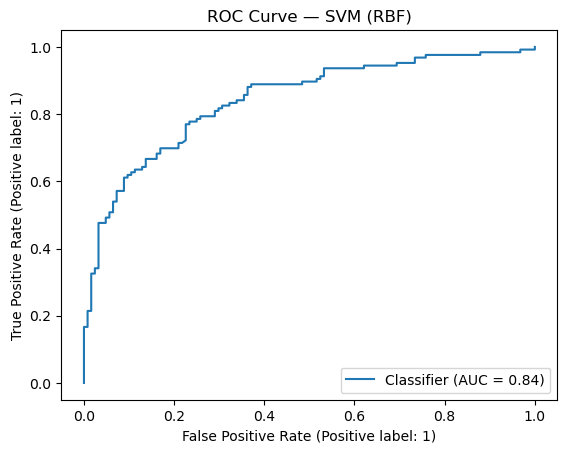

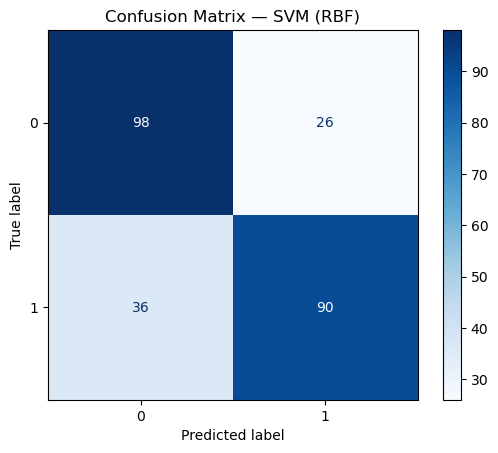

In [34]:
from sklearn.svm import SVC

svm_rbf = SVC(
    kernel="rbf",
    probability=True,   # to get predict_proba for ROC curve
    random_state=42
)

svm_rbf.fit(X_train_proc, y_train)

evaluate_model(
    svm_rbf,
    X_train_proc, y_train,
    X_test_proc, y_test,
    name="SVM (RBF)"
)

### SVM — Model Evaluation

We selected the RBF kernel because it handles non-linear relationships between features and mental-health risk, which a linear kernel cannot capture. It is also the most stable and effective default choice for medium-sized tabular datasets like ours, often giving better performance without heavy tuning.

The Support Vector Machine performs consistently well on the classification task. Its overall accuracy reaches **0.752**, which is slightly lower than Logistic Regression but still competitive.

- The model achieves a precision of **0.776**, meaning it is effective at avoiding false positives.
- Its recall of **0.714** indicates that it captures a reasonable portion of employees actually at risk.  
- The F1-score of **0.744** reflects a good balance between precision and recall.  
- The ROC-AUC of **0.842** shows strong discriminative ability, close to the best-performing model so far.

The confusion matrix reveals a balanced behavior. The model correctly identifies **98 employees not at risk** and **90 employees at risk**.  
Misclassifications remain moderate and relatively symmetric between the two classes.

Overall, the SVM (RBF) provides robust performance and is one of the strongest classical models in this comparison. Further tuning may improve it even more.

# Custom KNN implementation


Custom KNN — Test set metrics
Accuracy :  0.684
Precision: 0.764
Recall   : 0.540
F1-score : 0.633
ROC-AUC  : 0.730


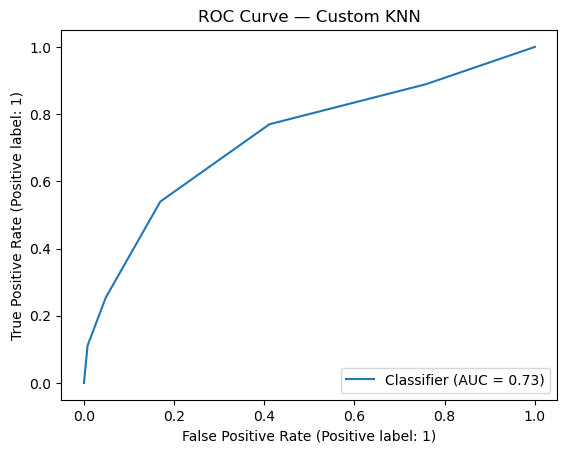

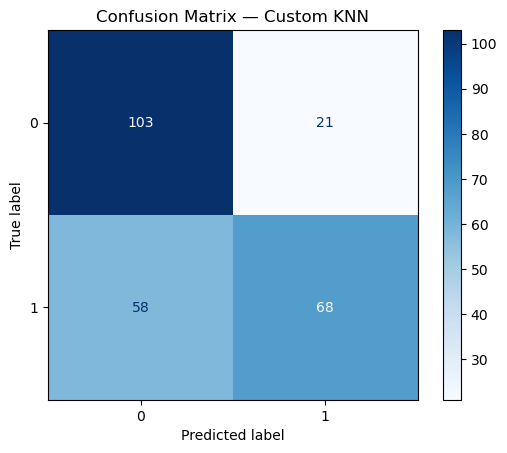

In [ ]:
from sklearn.metrics import pairwise_distances

class SimpleKNN:
    def __init__(self, n_neighbors=5):
        self.k = n_neighbors
        self.X_train = None
        self.y_train = None

    def fit(self, X, y):
        self.X_train = np.asarray(X)
        self.y_train = np.asarray(y)
        return self

    def _neighbors_proba(self, X):
        # Compute pairwise distances from test samples to training samples
        dists = pairwise_distances(X, self.X_train, metric="euclidean")
        # Indices of k nearest neighbors
        idx = np.argsort(dists, axis=1)[:, :self.k]
        # Neighbor labels
        neigh_labels = self.y_train[idx]
        # Probability of class 1 = mean of neighbor labels
        proba_1 = neigh_labels.mean(axis=1)
        return proba_1

    def predict(self, X):
        proba_1 = self._neighbors_proba(X)
        return (proba_1 >= 0.5).astype(int)

    def predict_proba(self, X):
        proba_1 = self._neighbors_proba(X)
        proba_0 = 1.0 - proba_1
        return np.vstack([proba_0, proba_1]).T
    

knn_custom = SimpleKNN(n_neighbors=5)
knn_custom.fit(X_train_proc, y_train)

evaluate_model(
    knn_custom,
    X_train_proc, y_train,
    X_test_proc, y_test,
    name="Custom KNN"
)

### Custom KNN — Model Evaluation

We implemented a simplified version of KNN manually to help us visualize how predictions depend directly on the nearest neighbors, without the optimizations or heuristics of scikit-learn.

The custom KNN model shows **the weakest performance** among all baseline models:

Accuracy **0.684** and F1-score **0.764** indicate that the model struggles to correctly classify both classes.
The precision is relatively high **0.764**, meaning that when the model predicts a risk of mental health issues (class 1), it is often correct.
However, the recall is low **0.540**, showing that the model misses many at-risk employees. 
The ROC-AUC of **0.730** confirms that the model has limited discriminative power compared to logistic regression or SVM.

#### Confusion Matrix
**False Negatives (58)**: A large number of at-risk employees are misclassified, which is critical in this context.
**True Positives (68)**: Some cases are correctly identified, but the number is significantly lower than with other models.

Overall, the custom KNN serves as a useful educational baseline but is clearly not competitive for this prediction task.

# Comparison table

In [ ]:
baseline_results = []

def add_result(name, model):
    y_pred = model.predict(X_test_proc)
    try:
        y_prob = model.predict_proba(X_test_proc)[:, 1]
        auc = roc_auc_score(y_test, y_prob)
    except Exception:
        auc = np.nan

    baseline_results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1-score": f1_score(y_test, y_pred),
        "ROC-AUC": auc
    })

add_result("Logistic Regression", log_reg)
add_result("Decision Tree", dt)
add_result("SVM RBF", svm_rbf)
add_result("Custom KNN", knn_custom)

baseline_df = pd.DataFrame(baseline_results)
baseline_df

,Model,Accuracy,Precision,Recall,F1-score,ROC-AUC
0,Logistic Regression,0.768,0.798246,0.722222,0.758333,0.836086
1,Decision Tree,0.732,0.770642,0.666667,0.714894,0.732527
2,SVM RBF,0.752,0.775862,0.714286,0.743802,0.842454
3,Custom KNN,0.684,0.764045,0.539683,0.632558,0.730319


## Conclusion

The baseline comparison highlights clear differences in the predictive capabilities of the four models tested. Overall, **Logistic Regression** and **SVM (RBF)** deliver the best performance, achieving the highest **ROC-AUC scores (0.836 and 0.842)**, which indicates strong discriminative power between employees at risk and not at risk of mental health issues.

- **Logistic Regression** stands out with the best balance across all metrics, especially **precision (0.798)** and **F1-score (0.758)**. This suggests that a linear decision boundary already captures meaningful structures in the data.
- **SVM (RBF)** performs similarly, slightly improving the ROC-AUC while maintaining a comparable precision–recall trade-off. Its ability to model non-linear relationships appears useful for this task.
- **Decision Tree** shows moderate performance, with lower generalization and higher variability, which is expected given its sensitivity to data splits.
- The **Custom KNN** exhibits the weakest performance overall, mainly due to limited ability to capture more complex patterns and its natural vulnerability to high-dimensional spaces.

These results collectively show that **linear and kernel-based models generalize better** than distance-based or tree-based models in predicting mental health risk from workplace and personal factors.


Having established a strong baseline, the next step is to explore **model improvement through hyperparameter tuning and advanced techniques**. This step will determine whether performance can be enhanced beyond the baseline metrics and whether more sophisticated patterns can be captured to better identify employees at risk of mental health issues.

# Hyperparameter Tuning

In [38]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

log_pipe = Pipeline([
    ("prep", preprocessor),
    ("model", LogisticRegression(max_iter=2000))
])

log_params = {
    "model__C": [0.01, 0.1, 1, 5, 10],
    "model__penalty": ["l2"],
    "model__solver": ["lbfgs"]
}

log_search = GridSearchCV(log_pipe, log_params, cv=5, scoring="roc_auc", n_jobs=-1)
log_search.fit(X_train, y_train)

log_best = log_search.best_estimator_

y_pred = log_best.predict(X_test)
y_prob = log_best.predict_proba(X_test)[:, 1]

log_results = {
    "Accuracy": accuracy_score(y_test, y_pred),
    "Precision": precision_score(y_test, y_pred),
    "Recall": recall_score(y_test, y_pred),
    "F1-score": f1_score(y_test, y_pred),
    "ROC-AUC": roc_auc_score(y_test, y_prob)
}

log_results

{'Accuracy': 0.796,
 'Precision': 0.8260869565217391,
 'Recall': 0.753968253968254,
 'F1-score': 0.7883817427385892,
 'ROC-AUC': 0.8504224270353302}

In [42]:
from sklearn.tree import DecisionTreeClassifier

dt_pipe = Pipeline([
    ("prep", preprocessor),
    ("model", DecisionTreeClassifier())
])

dt_params = {
    "model__max_depth": [3, 5, 8, 12, None],
    "model__min_samples_split": [2, 5, 10],
    "model__min_samples_leaf": [1, 2, 4],
    "model__criterion": ["gini", "entropy"]
}

dt_search = GridSearchCV(dt_pipe, dt_params, cv=5, scoring="roc_auc", n_jobs=-1)
dt_search.fit(X_train, y_train)

dt_best = dt_search.best_estimator_

y_pred = dt_best.predict(X_test)

y_prob = dt_best.predict_proba(X_test)[:, 1]

dt_results = {
    "Accuracy": accuracy_score(y_test, y_pred),
    "Precision": precision_score(y_test, y_pred),
    "Recall": recall_score(y_test, y_pred),
    "F1-score": f1_score(y_test, y_pred),
    "ROC-AUC": roc_auc_score(y_test, y_prob)
}

dt_results

{'Accuracy': 0.74,
 'Precision': 0.7163120567375887,
 'Recall': 0.8015873015873016,
 'F1-score': 0.7565543071161048,
 'ROC-AUC': 0.7956669226830517}

In [39]:
from sklearn.svm import SVC

svm_pipe = Pipeline([
    ("prep", preprocessor),
    ("model", SVC(kernel="rbf", probability=True))
])

svm_params = {
    "model__C": [0.1, 1, 5, 10],
    "model__gamma": ["scale", 0.1, 0.01, 0.001]
}

svm_search = GridSearchCV(svm_pipe, svm_params, cv=5, scoring="roc_auc", n_jobs=-1)
svm_search.fit(X_train, y_train)

svm_best = svm_search.best_estimator_

y_pred = svm_best.predict(X_test)
y_prob = svm_best.predict_proba(X_test)[:, 1]

svm_results = {
    "Accuracy": accuracy_score(y_test, y_pred),
    "Precision": precision_score(y_test, y_pred),
    "Recall": recall_score(y_test, y_pred),
    "F1-score": f1_score(y_test, y_pred),
    "ROC-AUC": roc_auc_score(y_test, y_prob)
}

svm_results

{'Accuracy': 0.752,
 'Precision': 0.7758620689655172,
 'Recall': 0.7142857142857143,
 'F1-score': 0.7438016528925621,
 'ROC-AUC': 0.8425179211469535}

### Results of Hyperparameter Tuning

After tuning the main models with GridSearchCV, we obtain the following performance on the test set:

| Model                   | Accuracy | Precision | Recall | F1-score | ROC-AUC |
|-------------------------|----------|-----------|--------|----------|---------|
| Tuned Logistic Regression | 0.796  | 0.826     | 0.754  | 0.788    | 0.850   |
| Tuned Decision Tree       | 0.740  | 0.716     | 0.802  | 0.757    | 0.794   |
| Tuned SVM (RBF)           | 0.752  | 0.776     | 0.714  | 0.744    | 0.843   |

##### Tuned Logistic Regression

The tuned Logistic Regression model shows a **clear improvement** compared to the baseline:

- Accuracy increases from 0.768 to **0.796**.  
- Precision and recall both improve, reaching **0.826** and **0.754** respectively.  
- The F1-score rises to **0.788**, and ROC-AUC reaches **0.850**.

This means the model is now better at correctly identifying employees at risk while still limiting false positives.  
Overall, tuned Logistic Regression becomes one of the most attractive models in terms of both performance and interpretability.

##### Tuned Decision Tree

For the Decision Tree, tuning changes the behaviour of the model:

- Accuracy slightly increases to **0.740**.  
- Recall becomes very high **0.802**, indicating that the model detects more at-risk employees.  
- However, ROC-AUC remains lower **0.794** than for Logistic Regression and SVM.

This tuned tree can be interesting in scenarios where **capturing as many at-risk employees as possible** is more important than global ranking performance, but it remains less robust overall.

##### Tuned SVM (RBF)

The tuned SVM (RBF) reaches:

- Accuracy = **0.752**  
- F1-score = **0.744**  
- ROC-AUC = **0.843**

These results are very close to the baseline SVM, which suggests that the original hyperparameters were already near a good configuration.  
SVM remains a strong model, but tuning does not bring a major gain compared to Logistic Regression.


Hyperparameter tuning confirms that **Logistic Regression (tuned)** offers the **best global trade-off** between accuracy, precision, recall and AUC. **Decision Tree (tuned)** is useful when **high recall** is desired, but its overall performance is more limited. SVM (RBF) remains competitive, with strong AUC, but benefits less from tuning on this dataset.